In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
#gpuの確認
print(torch.cuda.is_available())

True


In [2]:
#学習済みの分散表現をロードする
from torchtext.vocab import Vectors

english_fasttext_vectors = Vectors(name='drive/My Drive/wiki-news-300d-1M.vec')

print(english_fasttext_vectors.dim)
print(len(english_fasttext_vectors.itos))

100%|█████████▉| 999308/999994 [01:44<00:00, 9863.74it/s]

300
999994


In [3]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats+'))

区切り文字： !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['I', 'like', 'cats']


In [16]:
import torchtext
from torchtext.data.utils import get_tokenizer

#テキストに処理を行うFieldを定義
#fix_lengthはtokenの数
TEXT = torchtext.data.Field(sequential=True, use_vocab=True, tokenize=tokenizer_with_preprocessing,
                            lower=True, include_lengths=True, batch_first=True, fix_length=40,
                            init_token='<cls>', eos_token='<eos>')

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

#pandasでcsvを保存するときに、labelをintでキャストしておかないとエラーでるから注意
train_ds, val_ds, test_ds = torchtext.data.TabularDataset.splits(
    path='drive/My Drive/dataset/CBET/ekman', train='train.csv', validation='val.csv', 
    test='test.csv', format='csv', fields=[('Text', TEXT), ('Label', LABEL)])

In [127]:
#ボキャブラリを作成する
TEXT.build_vocab(train_ds, vectors=english_fasttext_vectors)

print(len(TEXT.vocab.stoi))
print(TEXT.vocab.stoi)

batch_size = 64
d_model = 300
output_dim = 5
N = 3
heads = 5
dropout_rate = 0.1

51711
defaultdict(<function _default_unk_index at 0x7fe3c66a3ea0>, {'<unk>': 0, '<pad>': 1, '<cls>': 2, '<eos>': 3, 'the': 4, 'to': 5, 'a': 6, 'i': 7, 'user': 8, 'of': 9, 'you': 10, 'and': 11, 'is': 12, 'in': 13, 'my': 14, 'for': 15, 'on': 16, 'it': 17, 'me': 18, 'that': 19, 'this': 20, 'with': 21, 'not': 22, 'be': 23, 'so': 24, 'your': 25, 'are': 26, 'have': 27, 'can': 28, 'at': 29, 's': 30, 'just': 31, 'life': 32, 'no': 33, 'what': 34, 'day': 35, 'like': 36, 'all': 37, 'people': 38, 'love': 39, 'when': 40, 'im': 41, 'its': 42, 'but': 43, 'dont': 44, 'do': 45, 'up': 46, 'out': 47, 'we': 48, 'from': 49, 'how': 50, 'get': 51, 'good': 52, 'was': 53, 'fear': 54, 'now': 55, 'one': 56, 'time': 57, 'about': 58, 'by': 59, 'they': 60, 'if': 61, 'will': 62, 'why': 63, 't': 64, 'insta': 65, 'as': 66, 'free': 67, 'new': 68, 'who': 69, 'an': 70, 'today': 71, 'or': 72, 'more': 73, 'night': 74, 'go': 75, 'smile': 76, 'happy': 77, 'live': 78, 'girl': 79, 'chat': 80, 'self': 81, 'our': 82, 'there': 83

In [128]:
#データローダを作成
train_dl = torchtext.data.Iterator(train_ds, batch_size=batch_size, train=True)
val_dl = torchtext.data.Iterator(val_ds, batch_size=batch_size, train=False, sort=False)
test_dl = torchtext.data.Iterator(test_ds, batch_size=batch_size, train=False, sort=False)

#テスト
batch = next(iter(val_dl))
print(len(batch.Text[0][0]))
print(batch.Label)

40
tensor([4, 0, 2, 0, 2, 4, 4, 3, 1, 4, 2, 2, 1, 2, 2, 2, 1, 2, 3, 3, 0, 3, 4, 1,
        1, 3, 0, 2, 4, 1, 2, 2, 2, 3, 1, 2, 4, 3, 3, 4, 0, 0, 1, 3, 0, 3, 4, 0,
        0, 1, 2, 2, 1, 1, 4, 3, 2, 3, 3, 3, 2, 4, 4, 2])


In [129]:
import math
from torch.autograd import Variable
import torch.nn.functional as F

#モデルの定義
class Embedder(nn.Module):
  def __init__(self, text_embedding_vecotrs):
    super(Embedder, self).__init__()
    self.embeddings = nn.Embedding.from_pretrained(
        embeddings=text_embedding_vecotrs, freeze=True)
    
  def forward(self, x):
    x = self.embeddings(x)
    return x

class PositionalEncoder(nn.Module):
  def __init__(self, d_model, max_seq_len=200, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_rate)
    # create constant 'pe' matrix with values dependant on 
    # pos and i
    pe = torch.zeros(max_seq_len, d_model)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pe = pe.to(device)

    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = \
            math.sin(pos / (10000 ** ((2 * i)/d_model)))
            pe[pos, i + 1] = \
            math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
 
    
  def forward(self, x):
    # make embeddings relatively larger
    x = x * math.sqrt(self.d_model)
    #add constant to embedding
    seq_len = x.size(1)
    pe = Variable(self.pe[:,:seq_len], requires_grad=False)
    
    x = x + pe
    return self.dropout(x)

In [130]:
def attention(q, k, v, d_k, mask=None, dropout=None):

  #queryとkeyの関連度をだす
  scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) #[batch, heads, length, length]
  #maskをかける
  if mask is not None:
    mask = mask.unsqueeze(1)
    scores = scores.masked_fill(mask==0, -1e9)

  #AttentionWeight
  scores = F.softmax(scores, dim=-1)
  attention_weight = scores

  if dropout is not None:
    scores = dropout(scores)
  #valueを取り出す
  output = torch.matmul(scores, v) #[batch, heads, length, d_model]
  return output, attention_weight

class MultiHeadAttention(nn.Module):
  def __init__(self, heads, d_model, dropout_rate=0.1):
    super().__init__()
    self.d_model = d_model
    self.d_k = d_model // heads
    self.h = heads
    self.q_linear = nn.Linear(d_model, d_model)
    self.k_linear = nn.Linear(d_model, d_model)
    self.v_linear = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(dropout_rate)
    self.out = nn.Linear(d_model, d_model)

  def forward(self, q, k, v, mask=None):
    bs = q.size(0)

    q = self.q_linear(q).view(bs, -1, self.h, self.d_k) #[batch_size, length, heads, d_k]
    k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
    v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    #
    scores, attention_weight = attention(q, k, v, self.d_k, mask, self.dropout)
    concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
    output = self.out(concat)
    return output, attention_weight

class FeedForward(nn.Module):
  def __init__(self, d_model, d_ff=2048, dropout_rate=0.1):
    super().__init__()
    self.linear_1 = nn.Linear(d_model, d_ff)
    self.dropout = nn.Dropout(dropout_rate)
    self.linear_2 = nn.Linear(d_ff, d_model)

  def forward(self, x):
    x = self.dropout(F.relu(self.linear_1(x)))
    x = self.linear_2(x)
    return x

In [131]:
class EncoderLayer(nn.Module):
  def __init__(self, d_model, heads, dropout_rate=0.1):
    super().__init__()
    #LayerNormalizetion
    self.norm_1 = nn.LayerNorm(d_model)
    self.norm_2 = nn.LayerNorm(d_model)

    self.attn = MultiHeadAttention(heads, d_model, dropout_rate=dropout_rate)
    self.ff = FeedForward(d_model, dropout_rate=dropout_rate)

    self.dropout_1 = nn.Dropout(dropout_rate)
    self.dropout_2 = nn.Dropout(dropout_rate)

  def forward(self, x, mask):
    x2 = self.norm_1(x)
    output, attention_weight = self.attn(x2, x2, x2, mask)
    x = x+self.dropout_1(output)
    x2 = self.norm_2(x)
    x = x+self.dropout_2(self.ff(x2))

    return x, attention_weight

In [132]:
import copy

def get_clones(module, N):
  return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
  def __init__(self, text_embedding_vecotrs, N, heads, dropout):
    super().__init__()
    self.N = N
    self.embed = Embedder(text_embedding_vecotrs)
    self.pe = PositionalEncoder(d_model, dropout_rate=dropout)
    self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
    self.norm = nn.LayerNorm(d_model)
  def forward(self, src, mask):
    x = self.embed(src)
    x = self.pe(x)
    for i in range(self.N):
      x, attention_weight = self.layers[i](x, mask)
    return self.norm(x), attention_weight

In [133]:
class TranformerEncoderClassification(nn.Module):
  def __init__(self, text_embedding_vecotrs, d_model, N, heads, output_dim=5, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(text_embedding_vecotrs, N, heads, dropout_rate)
    self.out = nn.Linear(d_model, output_dim)
    # 重み初期化処理
    nn.init.normal_(self.out.weight, std=0.02)
    nn.init.normal_(self.out.bias, 0)

  def forward(self, src, mask):
    x, attention_weight = self.encoder(src, mask)
    output = self.out(x[:, 0, :])
    return output, attention_weight

In [134]:
#テスト
batch = next(iter(train_dl))
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

# モデル構築
net = TranformerEncoderClassification(TEXT.vocab.vectors, d_model, 3, 5)
net.to(device)

# 入出力
x = batch.Text[0].to(device)
src_mask = (x != TEXT.vocab.stoi['<pad>']).unsqueeze(-2)
print(src_mask.shape)
x1, attention_weight = net(x, src_mask)

print("入力のテンソルサイズ：", x.shape)
print("出力のテンソルサイズ：", x1.shape)
print(attention_weight[0][0][0])

torch.Size([64, 1, 40])
入力のテンソルサイズ： torch.Size([64, 40])
出力のテンソルサイズ： torch.Size([64, 5])
tensor([0.0642, 0.0474, 0.0380, 0.0386, 0.0364, 0.0504, 0.0430, 0.0423, 0.0339,
        0.0279, 0.0360, 0.0350, 0.0300, 0.0304, 0.0294, 0.0390, 0.0410, 0.0351,
        0.0323, 0.0514, 0.0386, 0.0439, 0.0378, 0.0337, 0.0320, 0.0322, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward>)


In [135]:
net = TranformerEncoderClassification(TEXT.vocab.vectors, d_model, N, heads, output_dim, dropout_rate)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)


# TransformerBlockモジュールを初期化実行
net.encoder.apply(weights_init)

print('モデルの初期化')

モデルの初期化


In [136]:
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dl, "val": val_dl}

# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法の設定
learning_rate = 2e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [137]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  # GPUが使えるかを確認
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("使用デバイス：", device)
  print('-----start-------')
  # ネットワークをGPUへ
  net.to(device)

  # ネットワークがある程度固定であれば、高速化させる
  torch.backends.cudnn.benchmark = True

  # epochのループ
  for epoch in range(num_epochs):
    # epochごとの訓練と検証のループ
    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()  # モデルを訓練モードに
      else:
        net.eval()   # モデルを検証モードに

      epoch_loss = 0.0  # epochの損失和
      epoch_corrects = 0  # epochの正解数

      # データローダーからミニバッチを取り出すループ
      for batch in (dataloaders_dict[phase]):
        # batchはTextとLableの辞書オブジェクト

        # GPUが使えるならGPUにデータを送る
        inputs = batch.Text[0].to(device)  # 文章
        labels = batch.Label.to(device)  # ラベル

        # optimizerを初期化
        optimizer.zero_grad()

        # 順伝搬（forward）計算
        with torch.set_grad_enabled(phase == 'train'):
          input_mask = (inputs != TEXT.vocab.stoi['<pad>']).unsqueeze(-2)

          # Transformerに入力
          outputs, _ = net(inputs, input_mask)
          loss = criterion(outputs, labels)  # 損失を計算

          _, preds = torch.max(outputs, 1)  # ラベルを予測

          # 訓練時はバックプロパゲーション
          if phase == 'train':
            loss.backward()
            optimizer.step()

          # 結果の計算
          epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

      # epochごとのlossと正解率
      epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
      print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

  return net

In [138]:
num_epochs = 10
net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)
print({'次元数': d_model, 'Nx': N, 'ヘッド数': heads, 'クラス数': output_dim, 'ドロップアウト': dropout_rate})

使用デバイス： cuda:0
-----start-------
Epoch 1/10 | train |  Loss: 1.1274 Acc: 0.5484
Epoch 1/10 |  val  |  Loss: 0.9961 Acc: 0.6207
Epoch 2/10 | train |  Loss: 0.9692 Acc: 0.6224
Epoch 2/10 |  val  |  Loss: 0.9558 Acc: 0.6309
Epoch 3/10 | train |  Loss: 0.9224 Acc: 0.6432
Epoch 3/10 |  val  |  Loss: 0.9218 Acc: 0.6504
Epoch 4/10 | train |  Loss: 0.8832 Acc: 0.6600
Epoch 4/10 |  val  |  Loss: 0.9113 Acc: 0.6560
Epoch 5/10 | train |  Loss: 0.8515 Acc: 0.6762
Epoch 5/10 |  val  |  Loss: 0.9263 Acc: 0.6482
Epoch 6/10 | train |  Loss: 0.8193 Acc: 0.6882
Epoch 6/10 |  val  |  Loss: 0.9124 Acc: 0.6562
Epoch 7/10 | train |  Loss: 0.7843 Acc: 0.7031
Epoch 7/10 |  val  |  Loss: 0.9394 Acc: 0.6572
Epoch 8/10 | train |  Loss: 0.7589 Acc: 0.7132
Epoch 8/10 |  val  |  Loss: 0.8995 Acc: 0.6657
Epoch 9/10 | train |  Loss: 0.7271 Acc: 0.7260
Epoch 9/10 |  val  |  Loss: 0.9293 Acc: 0.6730
Epoch 10/10 | train |  Loss: 0.6943 Acc: 0.7392
Epoch 10/10 |  val  |  Loss: 0.9334 Acc: 0.6747
{'次元数': 300, 'Nx': 3, 'ヘッ

In [141]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net_trained.eval()
net_trained.to(device)

y_true = np.array([])
y_pred = np.array([])

epoch_corrects = 0

for batch in (test_dl):
  inputs = batch.Text[0].to(device)
  labels = batch.Label.to(device)

  with torch.set_grad_enabled(False):
    input_mask = (inputs != TEXT.vocab.stoi['<pad>']).unsqueeze(-2)
    outputs, _ = net_trained(inputs, input_mask)
    _, preds = torch.max(outputs, 1)
    
    y_true = np.concatenate([y_true, labels.to("cpu", torch.double).numpy()])
    y_pred = np.concatenate([y_pred, preds.to("cpu", torch.double).numpy()])

    epoch_corrects += torch.sum(preds == labels.data)

# 正解率
epoch_acc = epoch_corrects.double() / len(test_dl.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(test_dl.dataset),epoch_acc))

テストデータ4569個での正解率：0.6682


In [142]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.61      0.57       870
         1.0       0.78      0.74      0.76       900
         2.0       0.77      0.83      0.80      1063
         3.0       0.61      0.44      0.51       880
         4.0       0.62      0.70      0.66       856

    accuracy                           0.67      4569
   macro avg       0.66      0.66      0.66      4569
weighted avg       0.67      0.67      0.66      4569



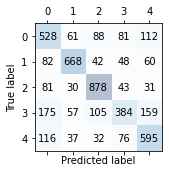

In [143]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

confmat = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()